In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib_venn import venn2
from src.tests.team_2.model_trainer_2 import load_data
from src.tests.team_2.model_trainer_2 import retrain
from src.utils.feature_analyzer import *
from src.utils.preprocessing import *
from src.utils.other_utils import *
from src.utils.test_utils import *



In [2]:
###PIPELINE###
# 1 load training data
# 2 evaluate feature importance with permutation feature
# 3 select top feature to create a test for bias
# 5 test if there is actually bias
# 6 choose that feature or not.
# 7 remove feature from training data
# 8 repeat (2-7) until we have 5 features we believe have the most bias



In [3]:
biased_features = []

In [4]:
###TRAIN: no features removed
# X, y = load_data('../../data/synth_data_train_labeled.csv')
# retrain(X, y)

In [5]:
###LOAD DATA
RANDOM_STATE = 42

# Load in data (go back two parent directories)
df = pd.read_csv('../../data/investigation_train_large_checked.csv')
# Load in data descriptions
data_desc = pd.read_csv('../../data/data_description.csv', encoding='ISO-8859-1')

# Replace dutch for english names
name_mapping = dict(zip(data_desc['Feature (nl)'], data_desc['Feature (en)']))
# Rename the columns in the `data` DataFrame
df.rename(columns=name_mapping, inplace=True)

# Show data head
df.head()


,address_number_personal_records_database_addresses,address_number_different_districts,address_number_mail_address,address_number_residential_address_manual,address_days_at_address,address_latest_part_rotterdam,address_latest_neighborhood_groot_ijsselmonde,address_latest_neighborhood_new_westen,address_latest_neighborhood_other,address_latest_neighborhood_olde_north,...,type_hist_ind,type_hist_care_sector,type_ind,type_indication_secret_data,type_other,type_transport_logistics_horticulture,type_care_cleaning_wellbeing,Ja,Nee,checked
0,1,1,0,0,23240,1,0,0,0,0,...,1,0,0,0,0,0,0,0.617698,0.382302,False
1,4,2,1,1,1971,1,0,0,1,0,...,1,0,1,0,1,0,0,0.602167,0.397833,False
2,6,4,2,1,7247,0,0,0,1,0,...,1,0,1,0,0,0,0,0.512377,0.487623,False
3,3,2,0,1,8060,1,0,0,1,0,...,1,0,0,0,0,0,0,0.717796,0.282204,True
4,3,2,0,0,18705,1,0,0,0,0,...,1,0,1,0,0,0,0,0.705484,0.294516,True


In [6]:
def analyze_features(data, cache, filename):
    fa = FeatureAnalyzer()
    if cache:
        fa.evaluate_importance(dataframe=data, target='checked', add_drop=['Ja', 'Nee'], filename=filename)
    fa = FeatureAnalyzer()
    fa.load_importance(filepath=filename)

    # Select original training data
    X = df.drop(['checked', 'Ja', 'Nee'], axis=1)
    y = df['checked']
    # Convert permutation importance to dictionary
    perm_import = fa.feature_importance_as_dict(column_names=X.columns, normalize=True)
    # Convert to pd series and sort from high to low
    perm_import = pd.Series(perm_import)
    # sort from high to low
    sorted_perm = perm_import.sort_values(ascending=False)

    top_5 = sorted_perm.head(5)
    top_5_sorted = top_5.sort_values(ascending=True)

    # Set the figure size for better readability
    plt.figure(figsize=(10,4))

    # Create a horizontal bar chart
    top_5_sorted.plot(kind='barh', color='skyblue')

    # Add titles and labels
    plt.title('Top 5 Feature based on Permutation Importances', fontsize=16)
    plt.xlabel('Importance Score', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    # Display sorted value
    for i, (value, feature) in enumerate(zip(top_5_sorted.values, top_5_sorted.index)):
        plt.text(value, i, f' {value:.2f}', va='center')
    # Enhance layout for better spacing
    plt.tight_layout()
    # Display the plot
    plt.show()


In [7]:
def plot_values(feature, data):
    counts = data[feature].value_counts().sort_index()

    plt.figure(figsize=(8,2))
    counts.plot(kind='bar', color='skyblue')
    plt.title(f'Frequency of {feature}', fontsize=14)
    plt.xlabel(f'{feature}', fontsize=14)
    plt.ylabel('Counts', fontsize=14)

In [8]:
def process_bias(data_path, model_path, feature, new_value, is_range):
    # change this with your dataset's path
    # data_path = '../../../data/Experiment_persoon_leeftijd_bij_onderzoek/20_only.csv'
    # model_path = "../../../model/gboost2.onnx" # replace with gboost2.onnx if you are working on the bad model
    #
    # # change this when you want to test a different feature
    # feature = 'persoon_leeftijd_bij_onderzoek'
    #
    # new_vals_range = (26, 68)

    if is_range:
        acc_original, acc_changed, p_value, dataset_size, original_checked_cnt, changed_checked_cnt = test_bias_with_range(
            data_path, model_path, feature, new_value)
    else:
        acc_original, acc_changed, p_value, dataset_size, original_checked_cnt, changed_checked_cnt = test_bias(
            data_path, model_path, feature, new_value)


    # Results messages (replace it with your own)
    print(f'Accuracy for sample of {dataset_size} Men: {acc_original * 100:.1f}%')
    print(f'Accuracy for sample of {dataset_size} Women: {acc_changed * 100:.1f}%')
    print(f'Percentage checked amongst 1000 men: {original_checked_cnt * 100 / dataset_size:.1f}%')
    print(f'Percentage checked when gender is changed to female: {changed_checked_cnt * 100 / dataset_size:.1f}%')

    if p_value < 0.05:
        print(f'Model showcases significant bias towards feature - {feature}')

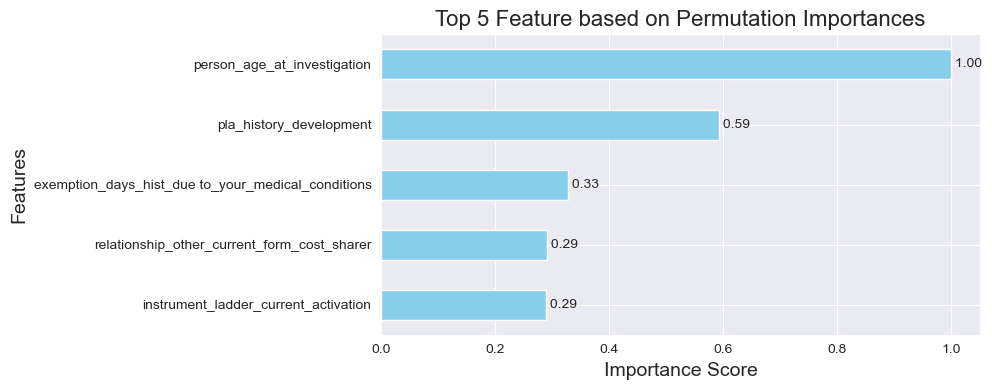

In [9]:
#ANALYZE: no features removed
analyze_features(df, False, 'feature_importance_1.pkl')

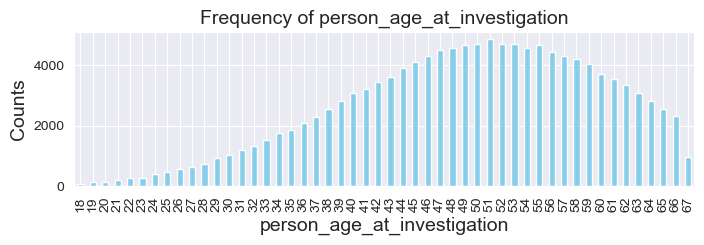

In [10]:
plot_values('person_age_at_investigation', df)

In [11]:
###TEST: bias on age
process_bias(
    data_path='../../data/Experiment_persoon_leeftijd_bij_onderzoek/20_only.csv',
    model_path='model/gboost2.onnx',
    feature='persoon_leeftijd_bij_onderzoek',
    new_value=(25,68),
    is_range=True
)


Accuracy for sample of 500 Men: 85.8%
Accuracy for sample of 500 Women: 79.8%
Percentage checked amongst 1000 men: 46.4%
Percentage checked when gender is changed to female: 36.8%
Model showcases significant bias towards feature - persoon_leeftijd_bij_onderzoek


In [12]:
###FEATURE SELECTION
biased_features.append('persoon_leeftijd_bij_onderzoek')

In [13]:
df = df.drop(name_mapping['persoon_leeftijd_bij_onderzoek'], axis=1)

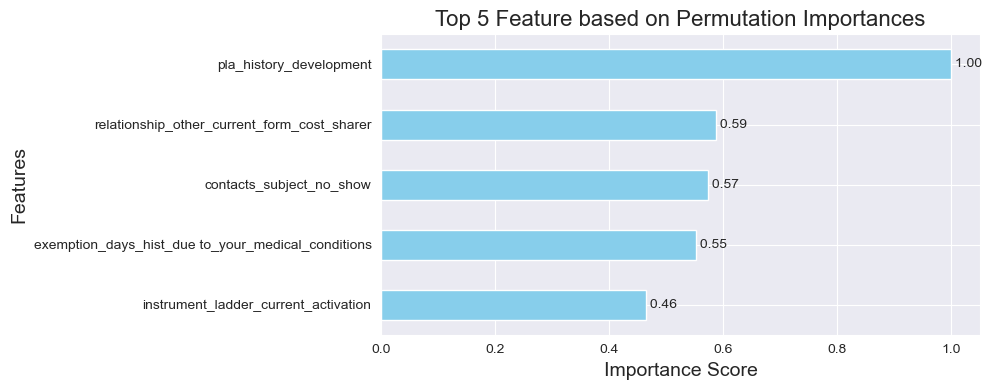

In [14]:
###REPEAT STEPS
analyze_features(df, False, 'feature_importance_2.pkl')

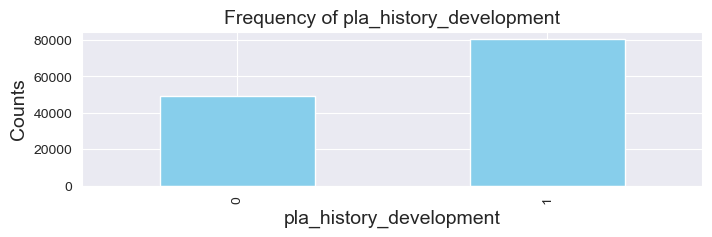

In [15]:
plot_values('pla_history_development', df)

In [16]:
###TEST: bias on history of plans
process_bias(
    data_path='../../data/Experiment_pla_historie_ontwikkeling/0_only.csv',
    model_path='model/gboost2.onnx',
    feature='pla_historie_ontwikkeling',
    new_value=1,
    is_range=False
)

Accuracy for sample of 500 Men: 92.4%
Accuracy for sample of 500 Women: 80.0%
Percentage checked amongst 1000 men: 40.6%
Percentage checked when gender is changed to female: 23.8%
Model showcases significant bias towards feature - pla_historie_ontwikkeling


In [17]:
###FEATURE SELECTION
biased_features.append('pla_historie_ontwikkeling')

In [18]:
df = df.drop(name_mapping['pla_historie_ontwikkeling'], axis=1)

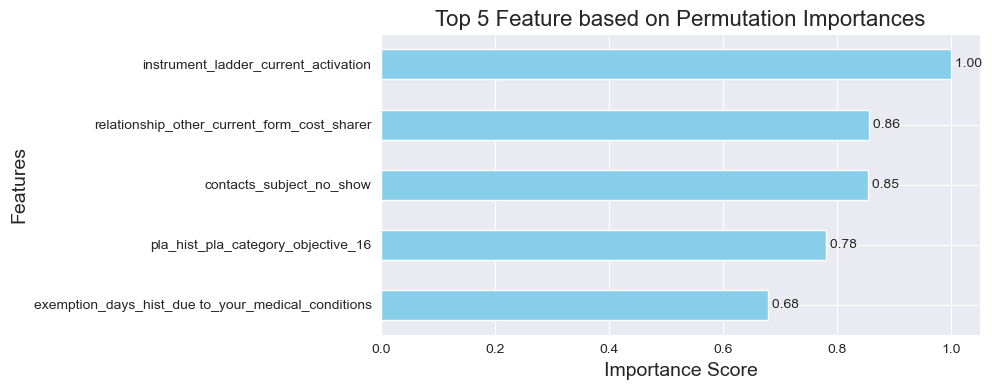

In [19]:
###REPEAT
analyze_features(df, False, 'feature_importance_3.pkl')

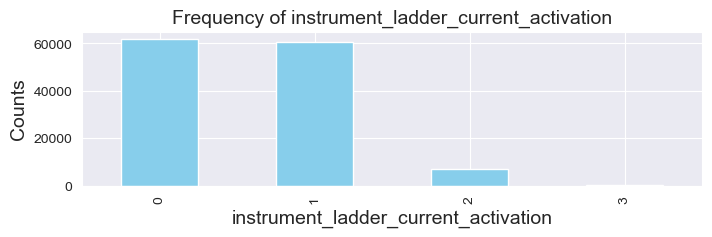

In [20]:
plot_values('instrument_ladder_current_activation', df)

In [21]:
###CONTINUE LATER: Once the test data is ready

### Data Manipulation

In [22]:
###Testing and example usage of manipulator
test_data = pd.read_csv('../../data/synth_data_train_labeled.csv')
test_data.describe()

,adres_aantal_brp_adres,adres_aantal_verschillende_wijken,adres_aantal_verzendadres,adres_aantal_woonadres_handmatig,adres_dagen_op_adres,adres_recentst_onderdeel_rdam,adres_recentste_buurt_groot_ijsselmonde,adres_recentste_buurt_nieuwe_westen,adres_recentste_buurt_other,adres_recentste_buurt_oude_noorden,...,typering_hist_inburgeringsbehoeftig,typering_hist_ind,typering_hist_sector_zorg,typering_ind,typering_indicatie_geheime_gegevens,typering_other,typering_transport__logistiek___tuinbouw,typering_zorg__schoonmaak___welzijn,Ja,Nee
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.00000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,2.881070,2.09822,0.430480,0.491710,9955.212070,0.951790,0.003920,0.003140,0.493880,0.001110,...,0.00801,0.999920,0.008600,0.677470,0.06613,0.425020,0.015250,0.007320,0.611093,0.388907
std,1.476058,0.92970,0.526184,0.560316,6342.036417,0.214211,0.062487,0.055948,0.499965,0.033298,...,0.08914,0.008944,0.092337,0.467447,0.24851,0.507859,0.122546,0.085244,0.086128,0.086128
min,1.000000,1.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.242658,0.150918
25%,2.000000,1.00000,0.000000,0.000000,4617.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.560066,0.327277
50%,3.000000,2.00000,0.000000,0.000000,9189.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,1.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.621726,0.378274
75%,4.000000,3.00000,1.000000,1.000000,14685.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.00000,1.000000,0.000000,1.000000,0.00000,1.000000,0.000000,0.000000,0.672723,0.439934
max,13.000000,8.00000,3.000000,3.000000,24329.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.00000,1.000000,1.000000,1.000000,1.00000,2.000000,1.000000,1.000000,0.849082,0.757342


In [23]:
from src.tests.team_2.model_trainer_2 import data_manipulator

manipulated_data = data_manipulator(
    data=test_data,
    feature='persoon_leeftijd_bij_onderzoek',
    manipulation='remove',
    fraction=0.5,
    remove_condition=lambda row: row['persoon_leeftijd_bij_onderzoek'] > 30
)
manipulated_data.describe()

,adres_aantal_brp_adres,adres_aantal_verschillende_wijken,adres_aantal_verzendadres,adres_aantal_woonadres_handmatig,adres_dagen_op_adres,adres_recentst_onderdeel_rdam,adres_recentste_buurt_groot_ijsselmonde,adres_recentste_buurt_nieuwe_westen,adres_recentste_buurt_other,adres_recentste_buurt_oude_noorden,...,typering_hist_inburgeringsbehoeftig,typering_hist_ind,typering_hist_sector_zorg,typering_ind,typering_indicatie_geheime_gegevens,typering_other,typering_transport__logistiek___tuinbouw,typering_zorg__schoonmaak___welzijn,Ja,Nee
count,52189.000000,52189.000000,52189.000000,52189.000000,52189.000000,52189.000000,52189.000000,52189.000000,52189.000000,52189.000000,...,52189.000000,52189.000000,52189.000000,52189.000000,52189.000000,52189.000000,52189.000000,52189.000000,52189.000000,52189.000000
mean,2.919255,2.121462,0.436720,0.499569,9745.965702,0.951484,0.003775,0.003085,0.494989,0.001226,...,0.007933,0.999904,0.008757,0.683650,0.067466,0.429497,0.014083,0.007166,0.614260,0.385740
std,1.495322,0.937977,0.528237,0.562919,6360.514125,0.214856,0.061323,0.055457,0.499980,0.034998,...,0.088713,0.009788,0.093167,0.465056,0.250830,0.509281,0.117836,0.084351,0.086237,0.086237
min,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.242658,0.150918
25%,2.000000,1.000000,0.000000,0.000000,4365.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.563321,0.324111
50%,3.000000,2.000000,0.000000,0.000000,8935.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.625189,0.374811
75%,4.000000,3.000000,1.000000,1.000000,14505.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.675889,0.436679
max,13.000000,7.000000,3.000000,3.000000,24327.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.849082,0.757342
